In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from boruta import BorutaPy
import optuna
import math
import collections

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [3]:
from xgboost import XGBRegressor

# Data

## Load

In [5]:
data_train = pd.read_csv('house_prices/datas/train.csv')
x_test = pd.read_csv('house_prices/datas/train.csv')
pd.set_option('display.max_columns', 90)

In [6]:
print(data_train.shape)
data_train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
print(x_test.shape)
x_test.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Analyse

### About Target

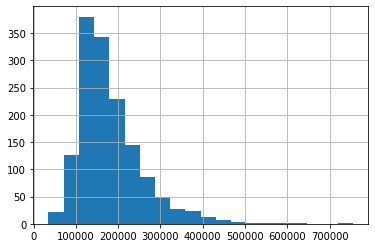

In [8]:
prices = data_train.SalePrice.hist(bins=20)

This histogram seems Distorted distribution to the right. So, It may be Lognormal distribution.

### About Features

In [9]:
print(data_train.dtypes.unique())
data_train.dtypes

[dtype('int64') dtype('O') dtype('float64')]


Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

---
Type 'object' has to be encoded numerical. 

In [10]:
collections.Counter(data_train.dtypes)

Counter({dtype('int64'): 35, dtype('O'): 43, dtype('float64'): 3})

# Preprocess

## Split data

In [11]:
_data_train = copy.deepcopy(data_train)
_x_test = copy.deepcopy(x_test)

In [12]:
x_train = _data_train.drop(['Id', 'SalePrice'], axis=1)
y_train = _data_train.SalePrice
id_test = _x_test.Id
x_test = _x_test.drop(['Id'], axis=1)

## Fix scale

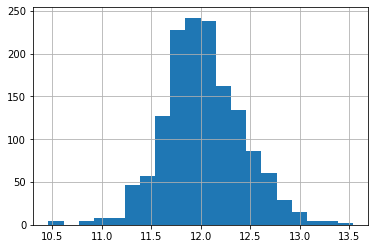

In [13]:
y_train_fix = np.log1p(y_train)
y_train_fix.hist(bins=20)

In this case, use y_train_fix as lognormal distribution.

## Cleaning

### Fill NaN

In [14]:
def  detect_nan(data):
    cols_isnan = []
    cols_isnan_set = []
    for i, isnan in enumerate(data.isnull().any()):
        if isnan is True:
            cols_isnan.append(data.columns[i])
            cols_isnan_set.append((data.columns[i], data.dtypes[i]))
    return cols_isnan, cols_isnan_set

In [15]:
train_cols_isnan, train_cols_isnan_set = detect_nan(x_train)
test_cols_isnan, test_cols_isnan_set = detect_nan(x_test)

In [16]:
train_cols_isnan_set

[('LotFrontage', dtype('float64')),
 ('Alley', dtype('O')),
 ('MasVnrType', dtype('O')),
 ('MasVnrArea', dtype('float64')),
 ('BsmtQual', dtype('O')),
 ('BsmtCond', dtype('O')),
 ('BsmtExposure', dtype('O')),
 ('BsmtFinType1', dtype('O')),
 ('BsmtFinType2', dtype('O')),
 ('Electrical', dtype('O')),
 ('FireplaceQu', dtype('O')),
 ('GarageType', dtype('O')),
 ('GarageYrBlt', dtype('float64')),
 ('GarageFinish', dtype('O')),
 ('GarageQual', dtype('O')),
 ('GarageCond', dtype('O')),
 ('PoolQC', dtype('O')),
 ('Fence', dtype('O')),
 ('MiscFeature', dtype('O'))]

In [17]:
test_cols_isnan_set

[('LotFrontage', dtype('float64')),
 ('Alley', dtype('O')),
 ('MasVnrType', dtype('O')),
 ('MasVnrArea', dtype('float64')),
 ('BsmtQual', dtype('O')),
 ('BsmtCond', dtype('O')),
 ('BsmtExposure', dtype('O')),
 ('BsmtFinType1', dtype('O')),
 ('BsmtFinType2', dtype('O')),
 ('Electrical', dtype('O')),
 ('FireplaceQu', dtype('O')),
 ('GarageType', dtype('O')),
 ('GarageYrBlt', dtype('float64')),
 ('GarageFinish', dtype('O')),
 ('GarageQual', dtype('O')),
 ('GarageCond', dtype('O')),
 ('PoolQC', dtype('O')),
 ('Fence', dtype('O')),
 ('MiscFeature', dtype('O'))]

In [18]:
cols_isnan = train_cols_isnan+test_cols_isnan
cols_isnan_set = train_cols_isnan_set+test_cols_isnan_set
types = [column[1] for column in cols_isnan_set]
uniques = set(types)
uniques

{dtype('float64'), dtype('O')}

In [19]:
def filled(data, cols):
    data_filled = copy.deepcopy(data)
    new_cols = [column+'_filled' for column in cols]
    for i, new_column in enumerate(new_cols):
        data_filled[new_column] = 0
        data_filled.loc[data_filled[cols[i]]!=data_filled[cols[i]], new_column] = 1
    data_filled['IsNaN'] = 0
    for index in range(len(data_filled)):
        if data_filled.iloc[index].isnull().any():
            data_filled['IsNaN'] = 1
    
    for column in cols:
        if data_filled[column].dtype=='object': 
            data_filled[column] = data_filled[column].fillna('NotAvailable')
        if data_filled[column].dtype=='float64':
            concat = pd.concat([x_train[column], x_test[column]])
            median = concat.median()
            data_filled[column] = data_filled[column].fillna(median)           
    return data_filled

In [20]:
x_train_filled = filled(x_train, cols_isnan)
x_test_filled = filled(x_test, cols_isnan)
x_train_filled.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,...,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_filled,Alley_filled,MasVnrType_filled,MasVnrArea_filled,BsmtQual_filled,BsmtCond_filled,BsmtExposure_filled,BsmtFinType1_filled,BsmtFinType2_filled,Electrical_filled,FireplaceQu_filled,GarageType_filled,GarageYrBlt_filled,GarageFinish_filled,GarageQual_filled,GarageCond_filled,PoolQC_filled,Fence_filled,MiscFeature_filled,IsNaN
0,60,RL,65.0,8450,Pave,NotAvailable,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,...,Typ,0,NotAvailable,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NotAvailable,NotAvailable,NotAvailable,0,2,2008,WD,Normal,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1
1,20,RL,80.0,9600,Pave,NotAvailable,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,...,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NotAvailable,NotAvailable,NotAvailable,0,5,2007,WD,Normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
2,60,RL,68.0,11250,Pave,NotAvailable,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,...,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NotAvailable,NotAvailable,NotAvailable,0,9,2008,WD,Normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
3,70,RL,60.0,9550,Pave,NotAvailable,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,...,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NotAvailable,NotAvailable,NotAvailable,0,2,2006,WD,Abnorml,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
4,60,RL,84.0,14260,Pave,NotAvailable,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,...,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NotAvailable,NotAvailable,NotAvailable,0,12,2008,WD,Normal,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1


### Encord categorical to numeric

In [21]:
cols_cat = [column for column in x_train_filled.columns \
                     if x_train_filled[column].dtype=='object']

In [22]:
encoders = {}
for column in cols_cat:
    encoders[column] = LabelEncoder()
    val = x_train_filled[column].tolist()
    val.extend(x_test_filled[column].tolist())
    encoders[column].fit(val)
    x_train_filled[column] = encoders[column].transform(x_train_filled[column])+1
    x_test_filled[column] = encoders[column].transform(x_test_filled[column])+1

In [23]:
x_train_filled.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,...,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_filled,Alley_filled,MasVnrType_filled,MasVnrArea_filled,BsmtQual_filled,BsmtCond_filled,BsmtExposure_filled,BsmtFinType1_filled,BsmtFinType2_filled,Electrical_filled,FireplaceQu_filled,GarageType_filled,GarageYrBlt_filled,GarageFinish_filled,GarageQual_filled,GarageCond_filled,PoolQC_filled,Fence_filled,MiscFeature_filled,IsNaN
0,60,4,65.0,8450,2,2,4,4,1,5,1,6,3,3,1,6,7,5,2003,2003,2,2,13,14,2,196.0,3,5,3,3,5,4,3,706,7,0,150,856,2,1,2,6,856,854,0,...,7,0,4,2,2003.0,3,2,548,6,6,3,0,61,0,0,0,0,4,5,2,0,2,2008,9,5,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1
1,20,4,80.0,9600,2,2,4,4,1,3,1,25,2,3,1,3,6,8,1976,1976,2,2,9,9,3,0.0,4,5,2,3,5,2,1,978,7,0,284,1262,2,1,2,6,1262,0,0,...,7,1,6,2,1976.0,3,2,460,6,6,3,298,0,0,0,0,0,4,5,2,0,5,2007,9,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
2,60,4,68.0,11250,2,2,1,4,1,5,1,6,3,3,1,6,7,5,2001,2002,2,2,13,14,2,162.0,3,5,3,3,5,3,3,486,7,0,434,920,2,1,2,6,920,866,0,...,7,1,6,2,2001.0,3,2,608,6,6,3,0,42,0,0,0,0,4,5,2,0,9,2008,9,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
3,70,4,60.0,9550,2,2,1,4,1,1,1,7,3,3,1,6,7,5,1915,1970,2,2,14,16,3,0.0,4,5,1,5,2,4,1,216,7,0,540,756,2,3,2,6,961,756,0,...,7,1,3,6,1998.0,4,3,642,6,6,3,0,35,272,0,0,0,4,5,2,0,2,2006,9,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
4,60,4,84.0,14260,2,2,1,4,1,3,1,16,3,3,1,6,8,5,2000,2000,2,2,13,14,2,350.0,3,5,3,3,5,1,3,655,7,0,490,1145,2,1,2,6,1145,1053,0,...,7,1,6,2,2000.0,3,3,836,6,6,3,192,84,0,0,0,0,4,5,2,0,12,2008,9,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1


## Feature Engineering

### ReAnalysis

In [24]:
df_train = copy.deepcopy(x_train_filled)
# df_train['SalePrice'] = y_train_fix
df_test = copy.deepcopy(x_test_filled)

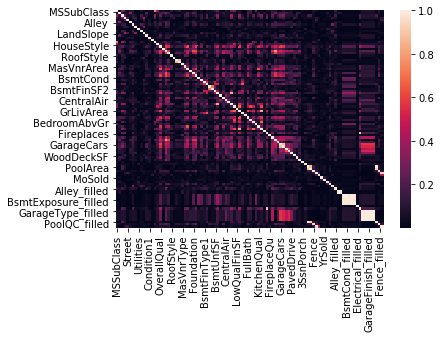

In [30]:
corr = df_train.corr(method='pearson').abs()
sns.heatmap(corr)

In [31]:
for col in df_train.columns:
    if df_train[col].dtype=='float64':
        if df_train[col].skew() > 0.75:
    #     train_set[col] = np.log1p(train_set[col])
    #     test_set[col] = np.log1p(test_set[col])
            print(col)

LotFrontage
MasVnrArea


### Filter Method

#### Reject variance 0

In [32]:
sel  = VarianceThreshold(threshold=0)
sel.fit(df_train)
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

---
Reject features which variance is 0 (i.e. same value) in train data.

In [33]:
df_train = df_train.loc[:, sel.get_support()]
df_test = df_test.loc[:, sel.get_support()]

IndexError: Item wrong length 98 instead of 100.

#### Reject variance 0.1

In [273]:
sel = VarianceThreshold(threshold=0.1)
sel.fit(df_train)
sel.get_support()

array([ True,  True,  True,  True, False, False,  True,  True, False,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False,  True, False])

---
Reject features which variance is 0.1 (i.e. about 99% is same value) in train data.

In [274]:
df_train = df_train.loc[:, sel.get_support()]
df_test = df_test.loc[:, sel.get_support()]

#### Reject high correlation coefficient

In [275]:
corr_matrix = df_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                                  k=1).astype(np.bool))
cols_to_drop = [column for column in upper.columns
                              if any(upper[column] > 0.8)]

In [276]:
[column for column in upper.columns if any(upper[column] > 0.8)]

['Exterior2nd',
 '1stFlrSF',
 'TotRmsAbvGrd',
 'GarageArea',
 'FireplaceQu_filled',
 'Fence_filled']

In [277]:
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

#### Matual Information

In [251]:
mi = mutual_info_regression(df_train, y_train_fix)
mi = pd.Series(mi)
mi.index = df_train.columns

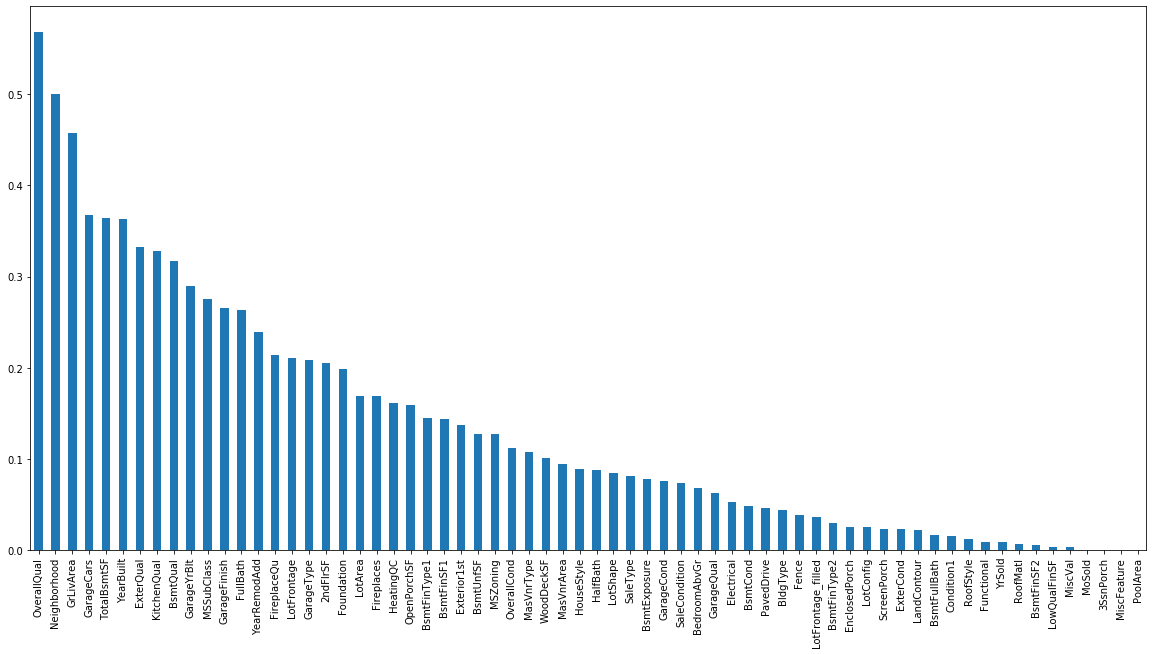

In [252]:
mi.sort_values(ascending=False).plot(kind='bar', figsize=(20,10))

# Learn

## Boruta

In [279]:
# rfr = RandomForestRegressor()
# feat_selecotr = BorutaPy(
#     rfr,
#     n_estimators='auto',
#     alpha=0.05,
#     two_step=False,
#     verbose=2,
#     perc=80,
#     max_iter=150
# )
# feat_selecotr.fit(df_train.to_numpy(), y_train_fix.to_numpy())

In [254]:
# df_train = df_train.loc[:, feat_selecotr.support_]
# df_test = df_test.loc[:, feat_selecotr.support_]

## Optuna

In [255]:
def objective(trial):
    # Booster Parameters
    eta = trial.suggest_loguniform('eta', 1e-1, 1e2)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    subsample = trial.suggest_loguniform('subsample', 0.5, 0.9)
    colsample_bytree = trial.suggest_loguniform('colsample_bytree', 0.1, 1.0)
    
    model =  XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        eta=eta,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    kf = KFold(5, shuffle=True).get_n_splits(0.3)
    rmse = np.sqrt(-cross_val_score(model, df_train,y_train_fix,
                                                                scoring="neg_mean_squared_error",
                                                                cv=kf, verbose=0))
    
    return rmse.mean()

In [256]:
study = optuna.create_study()

In [257]:
study.optimize(func=objective,
                            n_trials=300, 
                            timeout=None, 
                             n_jobs=-1)

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

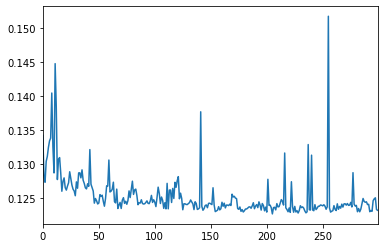

In [262]:
df_hist = study.trials_dataframe()
df_hist.value.plot()

## Create Model

In [263]:
# model = XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=1000,
#     eta=22.785680873817228,
#     learning_rate=0.042228848458044116,
#     max_depth=3,
#     min_child_weight=1,
#     subsample=0.7958054492496899,
#     colsample_bytree=0.20962423638803698
# )
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    eta=55.49482431640762,
    learning_rate=0.01430228151923028,
    max_depth=6,
    min_child_weight=1,
    subsample=0.5088078911826477,
    colsample_bytree=0.29484826893580957
)

## Fit

In [264]:
kf = KFold(5, shuffle=True).get_n_splits(df_train)
rmse = np.sqrt(-cross_val_score(model, df_train,y_train_fix,
                                                            scoring="neg_mean_squared_error",
                                                            cv=kf, verbose=0))
model.fit(df_train, y_train_fix)

/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yashima/anaconda3/envs/py37/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be remo

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.29484826893580957,
             eta=55.49482431640762, gamma=0, importance_type='gain',
             learning_rate=0.01430228151923028, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5088078911826477, verbosity=1)

In [265]:
print('---RMSE---')
print('CROSS : {}'.format(rmse))
print('MEAN : {}'.format(rmse.mean()))

---RMSE---
CROSS : [0.11048233 0.13726565 0.13103893 0.11129944 0.12329162]
MEAN : 0.12267559372937216


In [266]:
pred = np.expm1(model.predict(df_test))
print(pred[:5])

[126053.74 163534.53 190926.28 192438.62 192993.84]


# Submit

In [267]:
submit = pd.DataFrame({'Id':id_test, 'SalePrice':pred})
submit.to_csv('../data/submission_xgboost.csv', index=False)